# # Set 3 — Q4
# **Task:** Histogram-equalize the **Intensity** component of a color image in **HSI** space, then convert the new HSI image back to **RGB**.


In [1]:
# %%
# --- Imports & Config ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === User: set your image path here ===
img_path = "../image.jpg"

# If you prefer to hardcode during grading, set an absolute path (e.g., "D:/images/pic.jpg")
save_dir = Path("./outputs_q4")
save_dir.mkdir(parents=True, exist_ok=True)

def imshow(ax, img, title="", cmap=None):
    ax.imshow(img if cmap is None else img, cmap=cmap)
    ax.set_title(title)
    ax.axis("off")

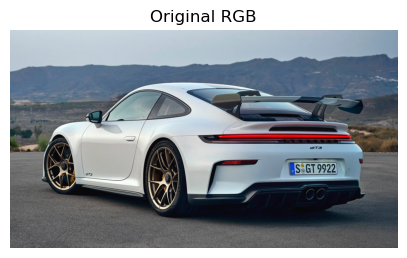

In [2]:
# %%
# --- Load image (RGB) ---
img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
if img_bgr is None:
    # Fallback: create a synthetic colorful demo image if the given path is missing
    h, w = 320, 480
    x = np.linspace(0, 1, w)
    y = np.linspace(0, 1, h)[:, None]
    r = (np.sin(2*np.pi*x)[None, :] * 0.5 + 0.5)
    g = (np.cos(2*np.pi*y) * 0.5 + 0.5)
    b = (0.6*np.ones((h, w)))
    demo = (np.stack([r*np.ones_like(g), g, b], axis=2) * 255).astype(np.uint8)
    img_rgb = demo
else:
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
imshow(ax, img_rgb, "Original RGB")
plt.show()

In [3]:
# %%
# --- RGB <-> HSI conversion (values in [0,1], hue in [0, 2π)) ---
# References: standard HSI definitions used in DIP texts (e.g., Gonzalez & Woods)

def rgb_to_hsi(img_rgb):
    img = img_rgb.astype(np.float32) / 255.0
    R, G, B = img[...,0], img[...,1], img[...,2]
    eps = 1e-8

    # Intensity
    I = (R + G + B) / 3.0

    # Saturation
    min_rgb = np.minimum(np.minimum(R, G), B)
    S = 1 - (min_rgb / (I + eps))
    S[I < eps] = 0.0  # avoid div-by-zero when very dark

    # Hue
    num = 0.5 * ((R - G) + (R - B))
    den = np.sqrt((R - G)**2 + (R - B)*(G - B)) + eps
    theta = np.arccos(np.clip(num / den, -1.0, 1.0))  # in [0, π]
    H = np.where(B <= R, theta, 2*np.pi - theta)      # in [0, 2π)

    # Normalize to [0,1] for convenience
    Hn = H / (2*np.pi)
    return Hn, S, I

def hsi_to_rgb(Hn, S, I):
    # H in [0,1]; convert to radians [0, 2π)
    H = Hn * 2*np.pi
    R = np.zeros_like(H, dtype=np.float32)
    G = np.zeros_like(H, dtype=np.float32)
    B = np.zeros_like(H, dtype=np.float32)

    # Sector 1: 0 <= H < 2π/3
    idx1 = (H >= 0) & (H < 2*np.pi/3)
    # Sector 2: 2π/3 <= H < 4π/3
    idx2 = (H >= 2*np.pi/3) & (H < 4*np.pi/3)
    # Sector 3: 4π/3 <= H < 2π
    idx3 = (H >= 4*np.pi/3) & (H < 2*np.pi)

    # Helper to avoid zero division
    eps = 1e-8

    # --- Sector 1 ---
    H1 = H[idx1]
    S1 = S[idx1]
    I1 = I[idx1]
    # Compute components
    B[idx1] = I1 * (1 - S1)
    R[idx1] = I1 * (1 + (S1 * np.cos(H1) / (np.cos(np.pi/3 - H1) + eps)))
    G[idx1] = 3*I1 - (R[idx1] + B[idx1])

    # --- Sector 2 ---
    H2 = H[idx2] - 2*np.pi/3
    S2 = S[idx2]
    I2 = I[idx2]
    R[idx2] = I2 * (1 - S2)
    G[idx2] = I2 * (1 + (S2 * np.cos(H2) / (np.cos(np.pi/3 - H2) + eps)))
    B[idx2] = 3*I2 - (R[idx2] + G[idx2])

    # --- Sector 3 ---
    H3 = H[idx3] - 4*np.pi/3
    S3 = S[idx3]
    I3 = I[idx3]
    G[idx3] = I3 * (1 - S3)
    B[idx3] = I3 * (1 + (S3 * np.cos(H3) / (np.cos(np.pi/3 - H3) + eps)))
    R[idx3] = 3*I3 - (G[idx3] + B[idx3])

    # Clip to [0,1] and return uint8 RGB
    rgb = np.stack([R, G, B], axis=2)
    rgb = np.clip(rgb, 0, 1)
    return (rgb * 255).astype(np.uint8)

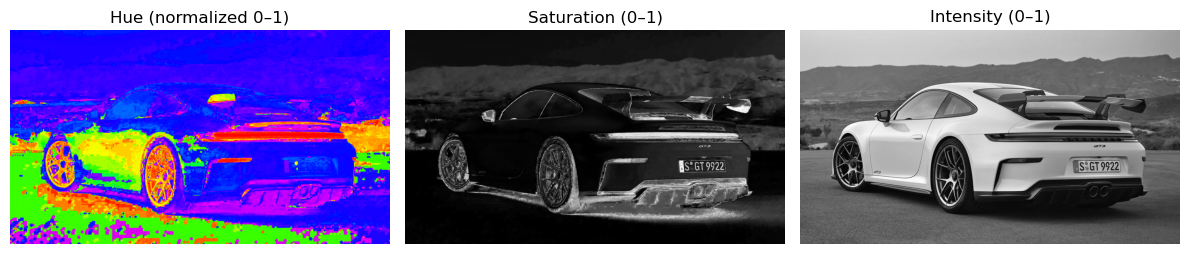

In [4]:
# %%
# --- Convert to HSI and visualize channels ---
H, S, I = rgb_to_hsi(img_rgb)

fig, axs = plt.subplots(1, 3, figsize=(12,4))
imshow(axs[0], H, "Hue (normalized 0–1)", cmap="hsv")
imshow(axs[1], S, "Saturation (0–1)", cmap="gray")
imshow(axs[2], I, "Intensity (0–1)", cmap="gray")
plt.tight_layout()
plt.show()

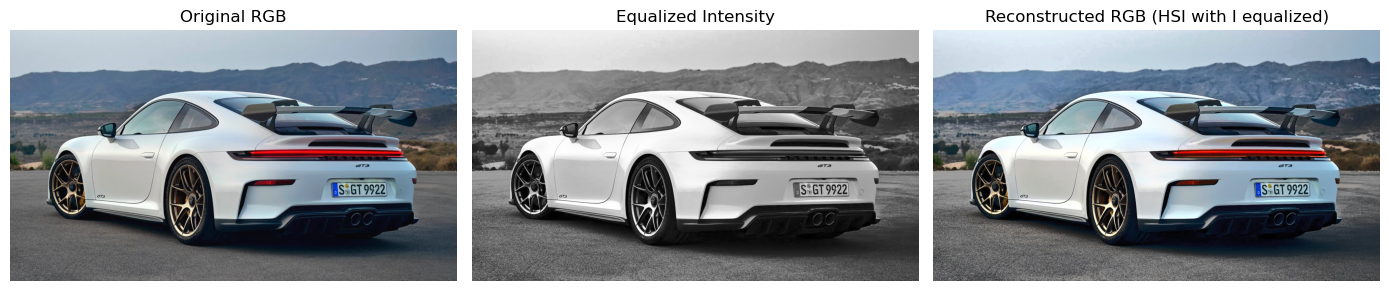

Saved images to: D:\git\Image and Video Processing\Lab_3\QUESTION4\outputs_q4


In [5]:
# %%
# --- Histogram equalization on Intensity channel ---
I_u8 = np.clip(I * 255.0, 0, 255).astype(np.uint8)
I_eq = cv2.equalizeHist(I_u8)
I_eq_f = I_eq.astype(np.float32) / 255.0

# Rebuild RGB from (H, S, I_eq)
rgb_eq = hsi_to_rgb(H, S, I_eq_f)

# Show results
fig, axs = plt.subplots(1, 3, figsize=(14,4))
imshow(axs[0], img_rgb, "Original RGB")
imshow(axs[1], I_eq, "Equalized Intensity", cmap="gray")
imshow(axs[2], rgb_eq, "Reconstructed RGB (HSI with I equalized)")
plt.tight_layout()
plt.show()

# Save outputs
cv2.imwrite(str(save_dir / "q4_original_rgb.png"), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
cv2.imwrite(str(save_dir / "q4_equalized_intensity.png"), I_eq)
cv2.imwrite(str(save_dir / "q4_reconstructed_rgb.png"), cv2.cvtColor(rgb_eq, cv2.COLOR_RGB2BGR))
print("Saved images to:", save_dir.resolve())